In [ ]:
# Install required packages
!pip install pandas matplotlib seaborn numpy statsmodels

# Optional: suppress warnings
import warnings
warnings.filterwarnings('ignore')

# TLS Handshake Performance Analysis

This notebook visualizes and compares the performance data of TLS handshakes using:
1. X25519 key exchange only
2. X25519MLKEM768 hybrid key exchange

In [14]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats

# Set styles for better visualization
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [15]:
# Configuration parameter for outlier removal
# Set to True to remove outliers in the data, False to keep all data points
remove_outliers = True

# Function to detect and remove outliers using the IQR method
def filter_outliers(df, column='duration_microseconds'):
    if not remove_outliers:
        return df  # Return original data if outlier removal is disabled
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for what constitutes an outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the dataframe to exclude outliers
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    print(f"Removed {len(df) - len(filtered_df)} outliers from {len(df)} data points")
    return filtered_df

In [16]:
# Load the CSV files
df_x25519_raw = pd.read_csv('timings_x25519.csv')
df_hybrid_raw = pd.read_csv('timings_hybrid.csv')

# Display the first few rows of each dataset
print("X25519 Dataset (Raw):")
display(df_x25519_raw.head())
print("\nX25519MLKEM768 Hybrid Dataset (Raw):")
display(df_hybrid_raw.head())

# Apply outlier filtering if enabled
df_x25519 = filter_outliers(df_x25519_raw)
df_hybrid = filter_outliers(df_hybrid_raw)

# Create a status message about the filtering
outlier_status = "(Outliers removed)" if remove_outliers else "(All data points included)"

X25519 Dataset (Raw):


,request_number,duration_microseconds
0,1,463082.828
1,2,41791.281
2,3,51893.964
3,4,46404.735
4,5,38586.054



X25519MLKEM768 Hybrid Dataset (Raw):


,request_number,duration_microseconds
0,1,741139.039
1,2,57916.917
2,3,40939.857
3,4,35006.403
4,5,39650.741


Removed 44 outliers from 1000 data points
Removed 33 outliers from 1000 data points


In [17]:
# Calculate basic statistics for both datasets
stats_x25519 = df_x25519['duration_microseconds'].describe()
stats_hybrid = df_hybrid['duration_microseconds'].describe()

print(f"X25519 Statistics {outlier_status}:")
print(f"Average handshake time: {stats_x25519['mean']:.2f} μs")
print(f"Minimum handshake time: {stats_x25519['min']:.2f} μs")
print(f"Maximum handshake time: {stats_x25519['max']:.2f} μs")
print(f"Standard deviation: {stats_x25519['std']:.2f} μs")

print(f"\nX25519MLKEM768 Hybrid Statistics {outlier_status}:")
print(f"Average handshake time: {stats_hybrid['mean']:.2f} μs")
print(f"Minimum handshake time: {stats_hybrid['min']:.2f} μs")
print(f"Maximum handshake time: {stats_hybrid['max']:.2f} μs")
print(f"Standard deviation: {stats_hybrid['std']:.2f} μs")

X25519 Statistics (Outliers removed):
Average handshake time: 19909.76 μs
Minimum handshake time: 12619.97 μs
Maximum handshake time: 32497.61 μs
Standard deviation: 4132.16 μs

X25519MLKEM768 Hybrid Statistics (Outliers removed):
Average handshake time: 17794.84 μs
Minimum handshake time: 11814.83 μs
Maximum handshake time: 27553.89 μs
Standard deviation: 3208.12 μs


In [18]:
# Calculate additional percentiles (95%, 98%, 99%) for both datasets
percentiles_x25519 = df_x25519['duration_microseconds'].quantile([0.95, 0.98, 0.99])
percentiles_hybrid = df_hybrid['duration_microseconds'].quantile([0.95, 0.98, 0.99])

print(f"X25519 Percentiles {outlier_status}:")
print(f"95th Percentile: {percentiles_x25519[0.95]:.2f} μs")
print(f"98th Percentile: {percentiles_x25519[0.98]:.2f} μs")
print(f"99th Percentile: {percentiles_x25519[0.99]:.2f} μs")

print(f"\nX25519MLKEM768 Hybrid Percentiles {outlier_status}:")
print(f"95th Percentile: {percentiles_hybrid[0.95]:.2f} μs")
print(f"98th Percentile: {percentiles_hybrid[0.98]:.2f} μs")
print(f"99th Percentile: {percentiles_hybrid[0.99]:.2f} μs")

X25519 Percentiles (Outliers removed):
95th Percentile: 27860.56 μs
98th Percentile: 30309.58 μs
99th Percentile: 31296.28 μs

X25519MLKEM768 Hybrid Percentiles (Outliers removed):
95th Percentile: 23720.79 μs
98th Percentile: 25452.41 μs
99th Percentile: 26429.26 μs


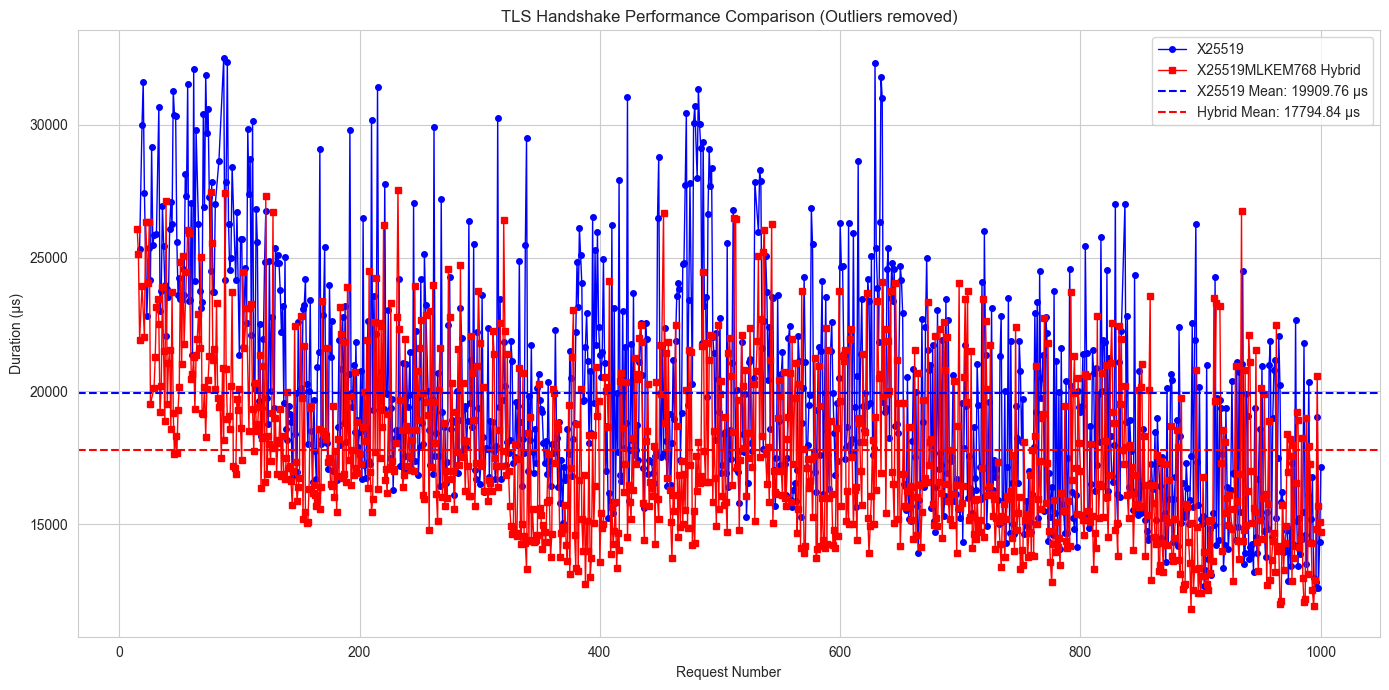

In [19]:
# Create a line plot comparing handshake times
plt.figure(figsize=(14, 7))

# Plot both datasets
plt.plot(df_x25519['request_number'], df_x25519['duration_microseconds'], 
         marker='o', linestyle='-', linewidth=1, markersize=4, color='blue', 
         label='X25519')
plt.plot(df_hybrid['request_number'], df_hybrid['duration_microseconds'], 
         marker='s', linestyle='-', linewidth=1, markersize=4, color='red', 
         label='X25519MLKEM768 Hybrid')

# Add mean lines
plt.axhline(y=stats_x25519['mean'], color='blue', linestyle='--', 
           label=f'X25519 Mean: {stats_x25519["mean"]:.2f} μs')
plt.axhline(y=stats_hybrid['mean'], color='red', linestyle='--', 
           label=f'Hybrid Mean: {stats_hybrid["mean"]:.2f} μs')

plt.title(f'TLS Handshake Performance Comparison {outlier_status}')
plt.xlabel('Request Number')
plt.ylabel('Duration (μs)')

# Only set ylim if we're not removing outliers to show full range
if not remove_outliers:
    plt.ylim(0, 25000)  # Adjust y-axis to better show the data excluding outliers

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f'tls_handshake_performance_comparison{"_no_outliers" if remove_outliers else ""}.png', dpi=300)
plt.show()

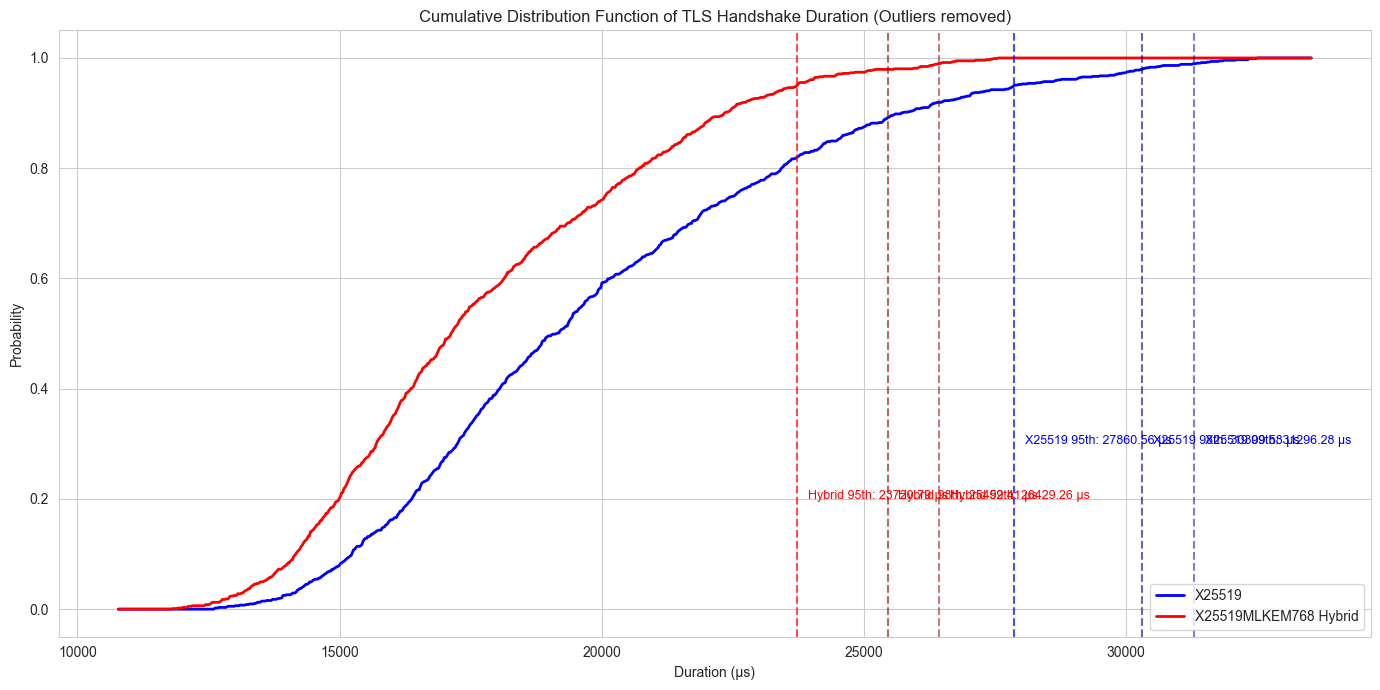

In [20]:
# Create Cumulative Distribution Function (CDF) plots for both datasets
# Compute the empirical CDFs
ecdf_x25519 = ECDF(df_x25519['duration_microseconds'])
ecdf_hybrid = ECDF(df_hybrid['duration_microseconds'])

# Create range for x-axis
x_min = min(df_x25519['duration_microseconds'].min(), df_hybrid['duration_microseconds'].min())
x_max = max(df_x25519['duration_microseconds'].max(), df_hybrid['duration_microseconds'].max())

# Add a margin to the range
x_range = x_max - x_min
x_min = max(0, x_min - 0.05 * x_range)
x_max = x_max + 0.05 * x_range

x = np.linspace(x_min, x_max, 1000)

# Calculate CDF values
y_x25519 = ecdf_x25519(x)
y_hybrid = ecdf_hybrid(x)

# Plot the CDFs
plt.figure(figsize=(14, 7))
plt.plot(x, y_x25519, 'b-', linewidth=2, label='X25519')
plt.plot(x, y_hybrid, 'r-', linewidth=2, label='X25519MLKEM768 Hybrid')

# Add percentile lines for X25519
for p, color, alpha in zip([0.95, 0.98, 0.99], ['blue', 'navy', 'darkblue'], [0.7, 0.6, 0.5]):
    p_value = df_x25519['duration_microseconds'].quantile(p)
    plt.axvline(p_value, color=color, linestyle='--', alpha=alpha)
    plt.text(p_value + 0.01 * x_range, 0.3, f'X25519 {int(p*100)}th: {p_value:.2f} μs', fontsize=9, color='blue')

# Add percentile lines for Hybrid
for p, color, alpha in zip([0.95, 0.98, 0.99], ['red', 'darkred', 'maroon'], [0.7, 0.6, 0.5]):
    p_value = df_hybrid['duration_microseconds'].quantile(p)
    plt.axvline(p_value, color=color, linestyle='--', alpha=alpha)
    plt.text(p_value + 0.01 * x_range, 0.2, f'Hybrid {int(p*100)}th: {p_value:.2f} μs', fontsize=9, color='red')

plt.title(f'Cumulative Distribution Function of TLS Handshake Duration {outlier_status}')
plt.xlabel('Duration (μs)')
plt.ylabel('Probability')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(f'tls_handshake_cdf_comparison{"_no_outliers" if remove_outliers else ""}.png', dpi=300)
plt.show()

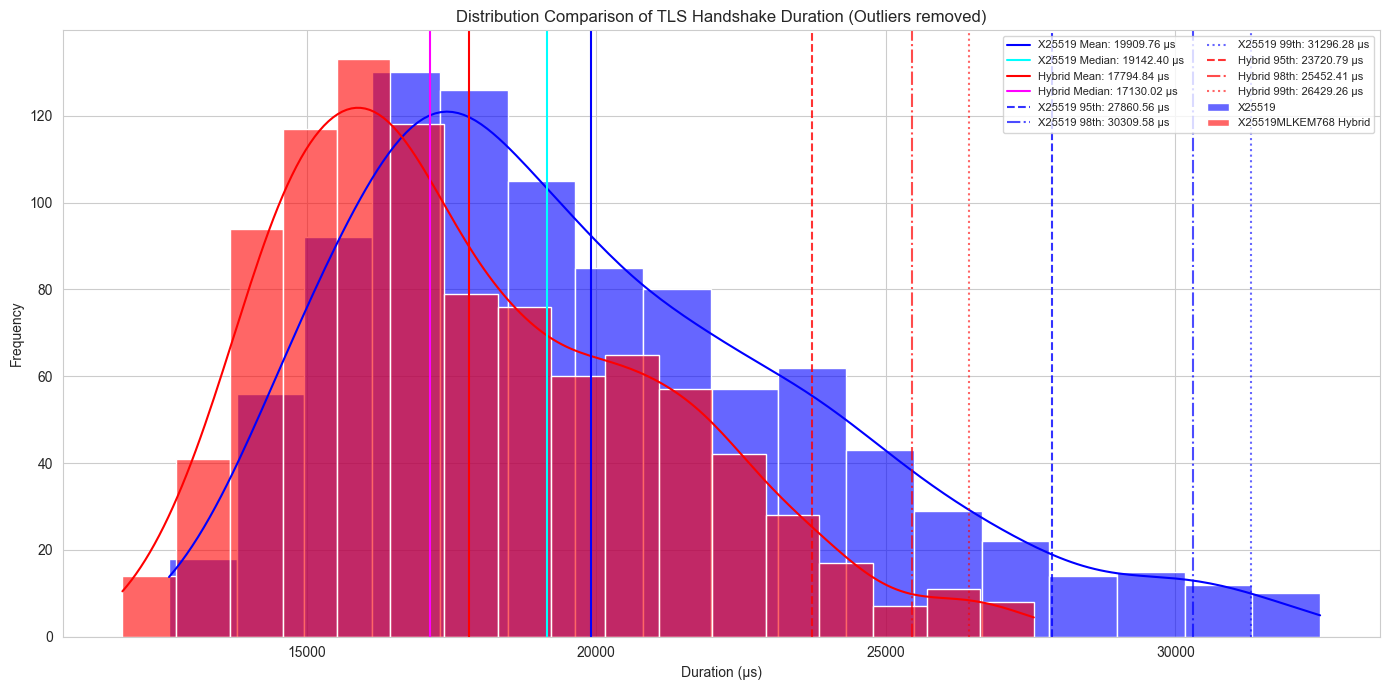

In [21]:
# Create histograms to compare the distribution of handshake times
plt.figure(figsize=(14, 7))

# Calculate best bin sizes using Freedman-Diaconis rule
def freedman_diaconis(data):
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    bin_width = 2 * iqr / (len(data) ** (1/3))
    bins = int((data.max() - data.min()) / bin_width) if bin_width > 0 else 30
    return max(10, min(bins, 50))  # Ensure bins are between 10 and 50

bins_x25519 = freedman_diaconis(df_x25519['duration_microseconds'])
bins_hybrid = freedman_diaconis(df_hybrid['duration_microseconds'])
bins = max(bins_x25519, bins_hybrid)

# Create histograms with appropriate bin sizes
sns.histplot(df_x25519['duration_microseconds'], kde=True, bins=bins,
             color='blue', alpha=0.6, label='X25519', legend=True)
sns.histplot(df_hybrid['duration_microseconds'], kde=True, bins=bins,
             color='red', alpha=0.6, label='X25519MLKEM768 Hybrid', legend=True)

# Add mean and median lines for X25519
plt.axvline(x=stats_x25519['mean'], color='blue', linestyle='-',
            label=f'X25519 Mean: {stats_x25519["mean"]:.2f} μs')
plt.axvline(x=stats_x25519['50%'], color='cyan', linestyle='-',
            label=f'X25519 Median: {stats_x25519["50%"]:.2f} μs')

# Add mean and median lines for Hybrid
plt.axvline(x=stats_hybrid['mean'], color='red', linestyle='-',
            label=f'Hybrid Mean: {stats_hybrid["mean"]:.2f} μs')
plt.axvline(x=stats_hybrid['50%'], color='magenta', linestyle='-',
            label=f'Hybrid Median: {stats_hybrid["50%"]:.2f} μs')

# Add 95%, 98%, 99% percentile lines for X25519
for p, ls, alpha in zip([0.95, 0.98, 0.99], ['--', '-.', ':'], [0.8, 0.7, 0.6]):
    p_value = df_x25519['duration_microseconds'].quantile(p)
    plt.axvline(x=p_value, color='blue', linestyle=ls, alpha=alpha,
                label=f'X25519 {int(p*100)}th: {p_value:.2f} μs')

# Add 95%, 98%, 99% percentile lines for Hybrid
for p, ls, alpha in zip([0.95, 0.98, 0.99], ['--', '-.', ':'], [0.8, 0.7, 0.6]):
    p_value = df_hybrid['duration_microseconds'].quantile(p)
    plt.axvline(x=p_value, color='red', linestyle=ls, alpha=alpha,
                label=f'Hybrid {int(p*100)}th: {p_value:.2f} μs')

plt.title(f'Distribution Comparison of TLS Handshake Duration {outlier_status}')
plt.xlabel('Duration (μs)')
plt.ylabel('Frequency')

# Create a legend with two columns to prevent overlap
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.tight_layout()
plt.savefig(f'tls_handshake_distribution_comparison{"_no_outliers" if remove_outliers else ""}.png', dpi=300)
plt.show()

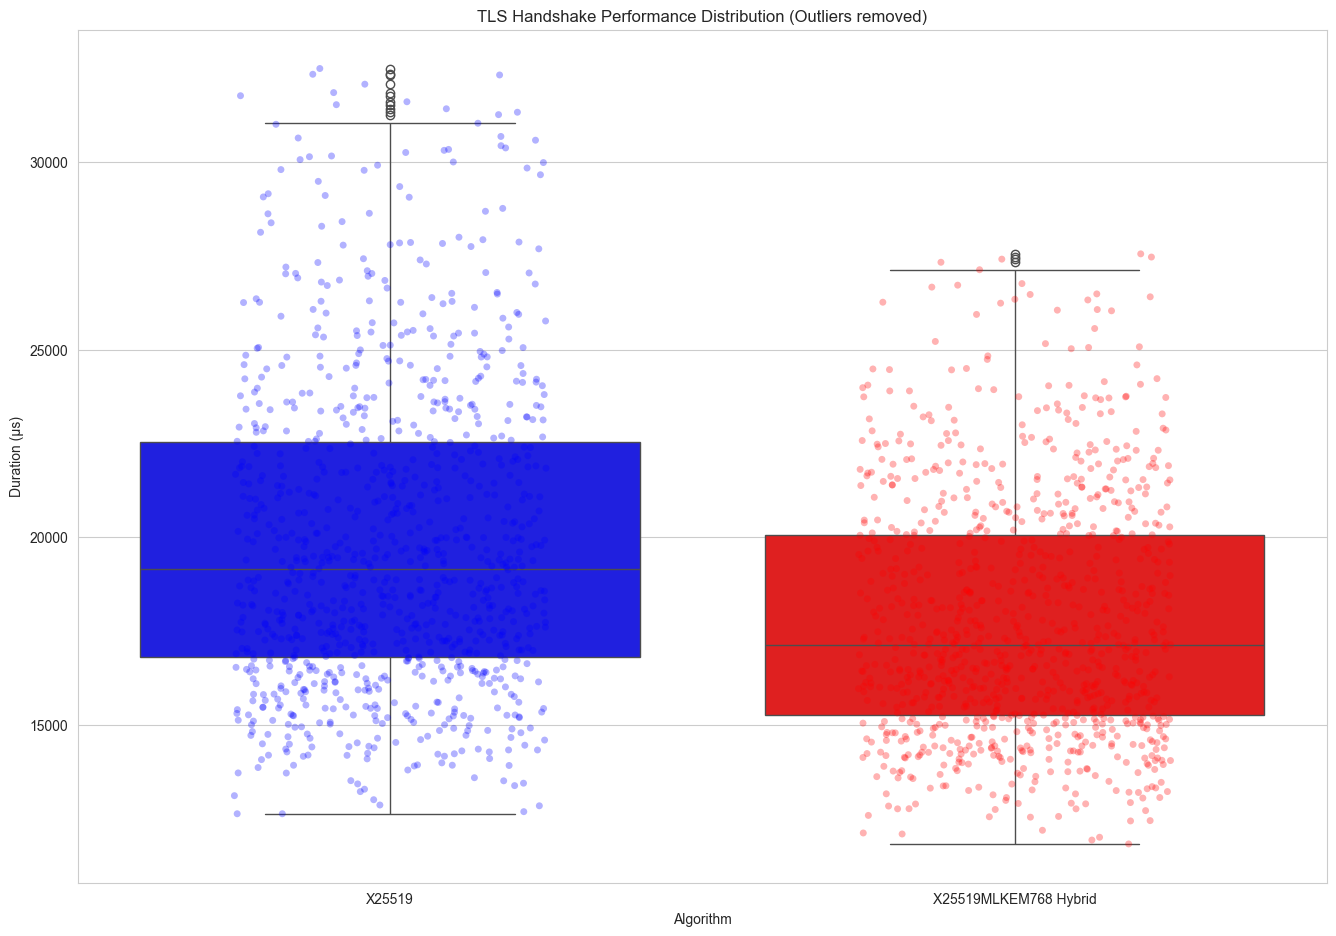

Percentile Comparison Table (Outliers removed):


,Percentile,X25519 (μs),X25519MLKEM768 (μs),Difference (μs),Difference (%)
0,5%,14468.75,13563.62,-905.13,-6.26
1,25%,16799.41,15261.07,-1538.34,-9.16
2,50%,19142.40,17130.02,-2012.38,-10.51
3,75%,22530.12,20066.52,-2463.61,-10.93
4,95%,27860.56,23720.79,-4139.77,-14.86
5,98%,30309.58,25452.41,-4857.17,-16.03
6,99%,31296.28,26429.26,-4867.02,-15.55


In [22]:
# Box plot comparison of the two algorithms
plt.figure(figsize=(14, 10))  # Increased height to prevent label overlapping

# Create a combined dataframe for box plotting
df_x25519_copy = df_x25519.copy()
df_hybrid_copy = df_hybrid.copy()

df_x25519_copy['Algorithm'] = 'X25519'
df_hybrid_copy['Algorithm'] = 'X25519MLKEM768 Hybrid'

df_combined = pd.concat([df_x25519_copy, df_hybrid_copy])

# Create the box plot
ax = sns.boxplot(x='Algorithm', y='duration_microseconds', data=df_combined, 
               palette={'X25519': 'blue', 'X25519MLKEM768 Hybrid': 'red'})

# Add data points with jitter for better visibility
sns.stripplot(x='Algorithm', y='duration_microseconds', data=df_combined,
            palette={'X25519': 'blue', 'X25519MLKEM768 Hybrid': 'red'},
            alpha=0.3, jitter=0.25)

# Customize the plot
plt.title(f'TLS Handshake Performance Distribution {outlier_status}')
plt.ylabel('Duration (μs)')
plt.tight_layout(pad=3.0)  # Increased padding to prevent label overlap
plt.savefig(f'tls_handshake_boxplot_comparison{"_no_outliers" if remove_outliers else ""}.png', dpi=300)
plt.show()

# Create a table of key percentiles for easy comparison
percentiles = [0.05, 0.25, 0.50, 0.75, 0.95, 0.98, 0.99]  # Added 98% percentile
x25519_percentiles = df_x25519['duration_microseconds'].quantile(percentiles)
hybrid_percentiles = df_hybrid['duration_microseconds'].quantile(percentiles)

# Calculate percentage difference at each percentile
percentile_diff = (hybrid_percentiles - x25519_percentiles) / x25519_percentiles * 100

# Create a DataFrame to display the results
comparison_table = pd.DataFrame({
    'Percentile': [f"{int(p*100)}%" for p in percentiles],
    'X25519 (μs)': x25519_percentiles.values.round(2),
    'X25519MLKEM768 (μs)': hybrid_percentiles.values.round(2),
    'Difference (μs)': (hybrid_percentiles - x25519_percentiles).values.round(2),
    'Difference (%)': percentile_diff.values.round(2)
})

print(f"Percentile Comparison Table {outlier_status}:")
display(comparison_table)

In [23]:
# Compare the effect of outlier removal on the results

# Load the original data again
df_x25519_with_outliers = df_x25519_raw
df_hybrid_with_outliers = df_hybrid_raw

# Calculate statistics with and without outliers
stats_x25519_with_outliers = df_x25519_with_outliers['duration_microseconds'].describe()
stats_hybrid_with_outliers = df_hybrid_with_outliers['duration_microseconds'].describe()

stats_x25519_no_outliers = df_x25519['duration_microseconds'].describe() if remove_outliers else None
stats_hybrid_no_outliers = df_hybrid['duration_microseconds'].describe() if remove_outliers else None

# Create comparison table for X25519
if remove_outliers:
    print("Effect of Outlier Removal on Statistics:")
    
    x25519_comparison = pd.DataFrame({
        'Statistic': ['Mean', 'Std Dev', 'Min', '25%', 'Median', '75%', 'Max'],
        'X25519 with Outliers': [
            stats_x25519_with_outliers['mean'].round(2),
            stats_x25519_with_outliers['std'].round(2),
            stats_x25519_with_outliers['min'].round(2),
            stats_x25519_with_outliers['25%'].round(2),
            stats_x25519_with_outliers['50%'].round(2),
            stats_x25519_with_outliers['75%'].round(2),
            stats_x25519_with_outliers['max'].round(2)
        ],
        'X25519 without Outliers': [
            stats_x25519_no_outliers['mean'].round(2),
            stats_x25519_no_outliers['std'].round(2),
            stats_x25519_no_outliers['min'].round(2),
            stats_x25519_no_outliers['25%'].round(2),
            stats_x25519_no_outliers['50%'].round(2),
            stats_x25519_no_outliers['75%'].round(2),
            stats_x25519_no_outliers['max'].round(2)
        ]
    })
    
    hybrid_comparison = pd.DataFrame({
        'Statistic': ['Mean', 'Std Dev', 'Min', '25%', 'Median', '75%', 'Max'],
        'Hybrid with Outliers': [
            stats_hybrid_with_outliers['mean'].round(2),
            stats_hybrid_with_outliers['std'].round(2),
            stats_hybrid_with_outliers['min'].round(2),
            stats_hybrid_with_outliers['25%'].round(2),
            stats_hybrid_with_outliers['50%'].round(2),
            stats_hybrid_with_outliers['75%'].round(2),
            stats_hybrid_with_outliers['max'].round(2)
        ],
        'Hybrid without Outliers': [
            stats_hybrid_no_outliers['mean'].round(2),
            stats_hybrid_no_outliers['std'].round(2),
            stats_hybrid_no_outliers['min'].round(2),
            stats_hybrid_no_outliers['25%'].round(2),
            stats_hybrid_no_outliers['50%'].round(2),
            stats_hybrid_no_outliers['75%'].round(2),
            stats_hybrid_no_outliers['max'].round(2)
        ]
    })
    
    print("\nX25519 Statistics Comparison:")
    display(x25519_comparison)
    
    print("\nX25519MLKEM768 Hybrid Statistics Comparison:")
    display(hybrid_comparison)
    
    # Display a message if outlier removal is disabled
else:
    print("Outlier removal is disabled. To see the effect of outlier removal on statistics, set 'remove_outliers = True' in the configuration cell.")

Effect of Outlier Removal on Statistics:

X25519 Statistics Comparison:


,Statistic,X25519 with Outliers,X25519 without Outliers
0,Mean,21345.42,19909.76
1,Std Dev,15461.68,4132.16
2,Min,12619.97,12619.97
3,25%,16916.44,16799.41
4,Median,19380.20,19142.40
5,75%,23164.63,22530.12
6,Max,463082.83,32497.61



X25519MLKEM768 Hybrid Statistics Comparison:


,Statistic,Hybrid with Outliers,Hybrid without Outliers
0,Mean,19022.47,17794.84
1,Std Dev,23271.46,3208.12
2,Min,11814.83,11814.83
3,25%,15352.81,15261.07
4,Median,17254.67,17130.02
5,75%,20371.46,20066.52
6,Max,741139.04,27553.89



===== HIGH PERCENTILE PERFORMANCE COMPARISON (Outliers removed) =====

At high percentiles (95%, 98%, 99%), the X25519MLKEM768 hybrid algorithm is:
15.48% faster than X25519 on average

Detailed high percentile statistics:


,Percentile,X25519 (μs),X25519MLKEM768 Hybrid (μs),Abs. Difference (μs),Rel. Difference (%)
0,95%,27860.56,23720.79,-4139.77,-14.86
1,98%,30309.58,25452.41,-4857.17,-16.03
2,99%,31296.28,26429.26,-4867.02,-15.55


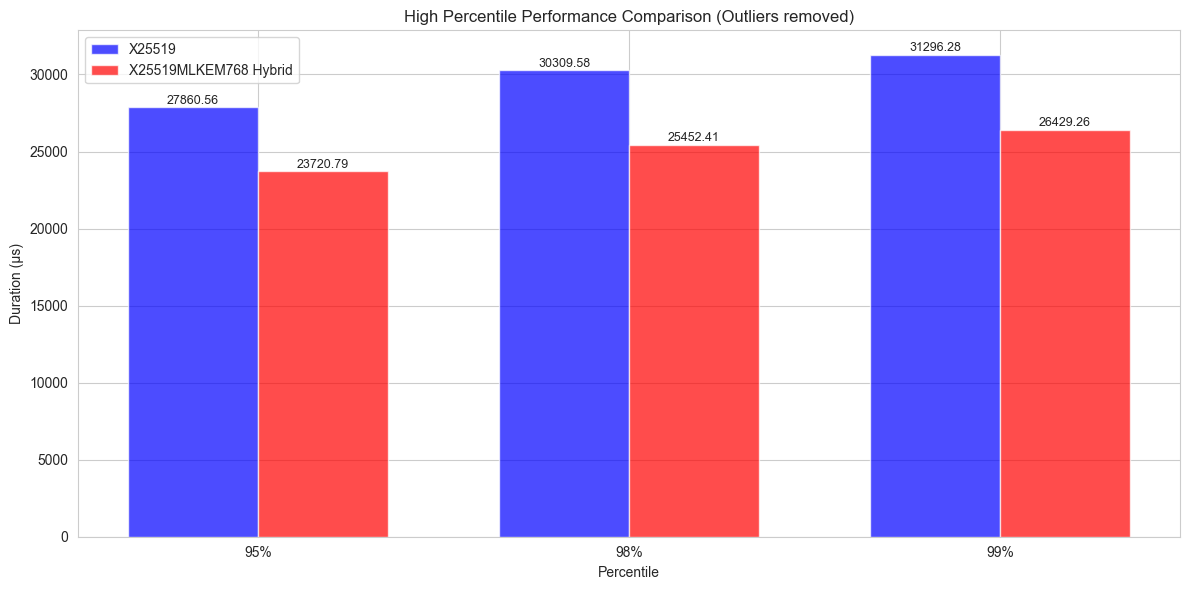

In [24]:
# Detailed high percentile (95%, 98%, 99%) comparison
high_percentiles = [0.95, 0.98, 0.99]

# Calculate high percentiles for both datasets
x25519_high_percentiles = df_x25519['duration_microseconds'].quantile(high_percentiles)
hybrid_high_percentiles = df_hybrid['duration_microseconds'].quantile(high_percentiles)

# Calculate raw and percentage differences
high_diff_raw = hybrid_high_percentiles - x25519_high_percentiles
high_diff_pct = (high_diff_raw / x25519_high_percentiles) * 100

# Create a DataFrame to display the results
high_percentile_table = pd.DataFrame({
    'Percentile': [f"{int(p*100)}%" for p in high_percentiles],
    'X25519 (μs)': x25519_high_percentiles.values.round(2),
    'X25519MLKEM768 Hybrid (μs)': hybrid_high_percentiles.values.round(2),
    'Abs. Difference (μs)': high_diff_raw.values.round(2),
    'Rel. Difference (%)': high_diff_pct.values.round(2)
})

# Calculate performance impact at high percentiles
high_percentile_impact = "slower" if high_diff_pct.mean() > 0 else "faster"

print(f"\n===== HIGH PERCENTILE PERFORMANCE COMPARISON {outlier_status} =====\n")
print(f"At high percentiles (95%, 98%, 99%), the X25519MLKEM768 hybrid algorithm is:")
print(f"{abs(high_diff_pct.mean()):.2f}% {high_percentile_impact} than X25519 on average")
print(f"\nDetailed high percentile statistics:")
display(high_percentile_table)

# Visualize high percentiles with a bar chart
plt.figure(figsize=(12, 6))
x = np.arange(len(high_percentiles))
width = 0.35

# Create bars
plt.bar(x - width/2, x25519_high_percentiles, width, label='X25519', color='blue', alpha=0.7)
plt.bar(x + width/2, hybrid_high_percentiles, width, label='X25519MLKEM768 Hybrid', color='red', alpha=0.7)

# Add labels and formatting
plt.title(f'High Percentile Performance Comparison {outlier_status}')
plt.xlabel('Percentile')
plt.ylabel('Duration (μs)')
plt.xticks(x, [f"{int(p*100)}%" for p in high_percentiles])

# Add value labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{height:.2f}',
                ha='center', va='bottom', rotation=0, fontsize=9)

# Add value labels to bars
add_labels(plt.gca().patches[:len(high_percentiles)])
add_labels(plt.gca().patches[len(high_percentiles):])

plt.legend()
plt.tight_layout()
plt.savefig(f'high_percentile_comparison{"_no_outliers" if remove_outliers else ""}.png', dpi=300)
plt.show()